In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [98]:
movie_reviews = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv', sep='\t')
movie_reviews.isnull().values.any()
movie_reviews.shape

(156060, 4)

In [99]:
#visualization of the dataset
movie_reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
#Regular expression for html tags
HTML_TAG_RE = re.compile(r'<[^>]+>')

#For removing html tags specially
def remove_tags(text):
    return HTML_TAG_RE.sub('', text)

#Preprocessing of text
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
#Preprocess the text by removing stop words
X = []
sentences = list(movie_reviews['Phrase'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [0]:
from keras.utils import np_utils
y = movie_reviews['Sentiment']

In [0]:
#Split the dataset into 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2003)

In [0]:
tokenizer = Tokenizer(num_words=5000)
#Updates internal vocabulary based on training data
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# One hot encoding for y variable
y_train = np_utils.to_categorical(y_train, num_classes=5)
y_test = np_utils.to_categorical(y_test, num_classes=5)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
#Convert the training sequences into 2D array
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:

from numpy import array
from numpy import asarray
from numpy import zeros

#Import GloVe word embeddings
embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

#Updating the dictionary with the pre-trained GloVe embeddings.
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
from keras.layers.convolutional import Conv1D

#Create sequential learning model
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
#Avoid overfitting
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [108]:
from keras import backend as K

def recall_m(y_true, y_pred):
  #True positive
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #Acutal positive
  ap = K.sum(K.round(K.clip(y_true, 0, 1)))
  #Calculate recall
  recall = tp / (ap + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  #True positive
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #Predicted positive
  pp = K.sum(K.round(K.clip(y_pred, 0, 1)))
  #Calculate Precision
  precision = tp / (pp + K.epsilon())
  return precision

#Calculate F1 score
def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['acc', f1_m, precision_m, recall_m])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1510300   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
dropout_9 (Dropout)          (None, 96, 128)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

In [109]:
history = model.fit(X_train, y_train, batch_size=200, epochs=100, validation_split=0.3, verbose=0)
# print the training results after every 11 epochs
for i in range(0,10):
  print("Accuracy for epoch %s : %.2f%%" % (i*11, history.history.get('val_acc')[i*11]))

Accuracy for epoch 0 : 0.56%
Accuracy for epoch 11 : 0.63%
Accuracy for epoch 22 : 0.64%
Accuracy for epoch 33 : 0.64%
Accuracy for epoch 44 : 0.64%
Accuracy for epoch 55 : 0.64%
Accuracy for epoch 66 : 0.65%
Accuracy for epoch 77 : 0.64%
Accuracy for epoch 88 : 0.65%
Accuracy for epoch 99 : 0.64%


In [110]:
#Evaluate the model using actual target using model.evaluate()
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

# For visualization, let's calculate the predicted target value
#using model.predict() function
# and calculate the confusion matrix
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

#Print the confusion matrix
print(classification_report(np.argmax(y_test, axis=1), y_pred_bool))

46818/46818 [==============================] - 1s 20us/step
              precision    recall  f1-score   support

           0       0.55      0.22      0.31      2151
           1       0.52      0.50      0.51      8070
           2       0.72      0.81      0.76     23987
           3       0.56      0.54      0.55      9872
           4       0.55      0.37      0.44      2738

    accuracy                           0.65     46818
   macro avg       0.58      0.49      0.52     46818
weighted avg       0.63      0.65      0.63     46818



In [111]:
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Loss: 0.9480912561902243
Accuracy: 0.6451792045794352
F1_score: 0.6314834627481236
Precision: 0.6700097479056994
Recall: 0.5982100901362724


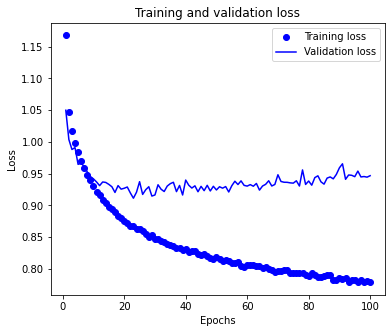

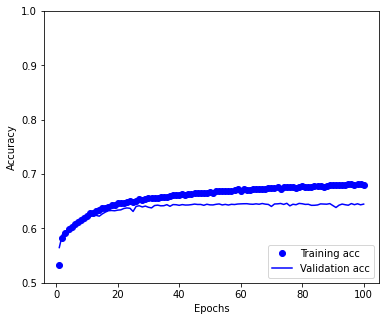

In [112]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(6,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [113]:
from keras.models import model_from_json
#saving the model on the disk

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [114]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 64.52%
